In [2]:
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModel
import torch

# ------------------------------
# Données
# ------------------------------
sent1 = "Le voyant rouge de ma Freebox clignote"
sent2 = "Ma box est en panne totale, plus de connexion"

# ------------------------------
# 1. Similarité via E5-base-v2
# ------------------------------
e5_model = SentenceTransformer("intfloat/e5-base-v2")
e5_emb1 = e5_model.encode(sent1, convert_to_tensor=True)
e5_emb2 = e5_model.encode(sent2, convert_to_tensor=True)
e5_sim = util.cos_sim(e5_emb1, e5_emb2).item()
print(f"[E5] Similarité Cosinus : {e5_sim:.4f}")

# ------------------------------
# 2. Similarité via Mini LLM (ex: TinyLlama, Phi, etc.)
# ------------------------------
llm_model_id = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"  # rapide et multilingue
tokenizer = AutoTokenizer.from_pretrained(llm_model_id)
model = AutoModel.from_pretrained(llm_model_id)

def get_embedding(text):
    encoded = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        model_output = model(**encoded)
    # Moyenne des embeddings (CLS pooling optionnel)
    embeddings = model_output.last_hidden_state.mean(dim=1)
    return embeddings

llm_emb1 = get_embedding(sent1)
llm_emb2 = get_embedding(sent2)

# Calcul cosine manuellement
cos_sim = torch.nn.functional.cosine_similarity(llm_emb1, llm_emb2).item()
print(f"[Mini LLM] Similarité Cosinus : {cos_sim:.4f}")



c:\Users\Eliot\Desktop\projet_rncp\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[E5] Similarité Cosinus : 0.8549
[Mini LLM] Similarité Cosinus : 0.4491


In [10]:
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModel
import torch
import itertools

# ------------------------------
# Phrases SAV (x2)
# ------------------------------
sentences = [
    "query: Le voyant rouge de ma Freebox clignote",
    "query: j'aime manger"
]

# ------------------------------
# 1. Embeddings via E5-base-v2
# ------------------------------
e5_model = SentenceTransformer("intfloat/e5-base-v2")
e5_embeddings = e5_model.encode(sentences, convert_to_tensor=True)

# ------------------------------
# 2. Embeddings via Mini LLM
# ------------------------------
llm_model_id = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
tokenizer = AutoTokenizer.from_pretrained(llm_model_id)
model = AutoModel.from_pretrained(llm_model_id)

def get_embedding(text):
    encoded = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        output = model(**encoded)
    return output.last_hidden_state.mean(dim=1)

llm_embeddings = [get_embedding(s.replace("query: ", "")) for s in sentences]  # MiniLM ne veut pas du préfixe

# ------------------------------
# 3. Affichage des similarités
# ------------------------------
print("\n=== Similarités Cosinus ===\n")

pairs = list(itertools.combinations(range(len(sentences)), 2))
for i, j in pairs:
    # E5
    sim_e5 = util.cos_sim(e5_embeddings[i], e5_embeddings[j]).item()
    # Mini LLM
    sim_llm = torch.nn.functional.cosine_similarity(llm_embeddings[i], llm_embeddings[j]).item()
    
    print(f"[E5]    {i}-{j}: {sim_e5:.4f}")
    print(f"[Mini]  {i}-{j}: {sim_llm:.4f}")
    print(f"        '{sentences[i].replace('query: ', '')}'")
    print(f"        '{sentences[j].replace('query: ', '')}'\n")



=== Similarités Cosinus ===

[E5]    0-1: 0.7674
[Mini]  0-1: 0.0660
        'Le voyant rouge de ma Freebox clignote'
        'j'aime manger'



In [5]:
from sentence_transformers import SentenceTransformer, util

queries = ["Le voyant rouge de ma Freebox clignote"]
passages = [
    "j'aime manger",
    "Plus de connexion sur ma Freebox, panne totale",
    "Le voyant clignote rouge et plus d'accès Internet"
]

model = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1")
query_emb = model.encode(queries, convert_to_tensor=True)
passage_emb = model.encode(passages, convert_to_tensor=True)

sims = util.cos_sim(query_emb, passage_emb)

for i, p in enumerate(passages):
    print(f"→ Similarité avec : '{p}' = {sims[0][i].item():.4f}")


→ Similarité avec : 'j'aime manger' = 0.5477
→ Similarité avec : 'Plus de connexion sur ma Freebox, panne totale' = 0.7707
→ Similarité avec : 'Le voyant clignote rouge et plus d'accès Internet' = 0.8786


In [5]:
from sentence_transformers import SentenceTransformer, util

sentences = [
    "Le voyant rouge de ma Freebox clignote",
    "j'aime manger",
    "Plus de connexion sur ma Freebox, panne totale",
    "Le voyant clignote rouge et plus d'accès Internet"
]

model = SentenceTransformer("jinaai/jina-embeddings-v2-base-en")  # ← ✅ correct
embeddings = model.encode(sentences, convert_to_tensor=True)

# Similarité avec la phrase 0
for i in range(1, len(sentences)):
    sim = util.cos_sim(embeddings[0], embeddings[i]).item()
    print(f"→ Similarité avec : '{sentences[i]}' = {sim:.4f}")


Some weights of BertModel were not initialized from the model checkpoint at jinaai/jina-embeddings-v2-base-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encoder.layer.10.intermediate.dense.bias', 'encoder.layer.10.intermediate.dense.weight', 'encoder.layer.10.output.LayerNorm.bias', 'encoder.layer.10.output.LayerNorm.weight', 'encoder.layer.10.output.dense.bias', 'encoder.layer.10.output.dense.weight', 'encoder.layer.11.intermediate.dense.bias', 'encoder.layer.11.intermedi

→ Similarité avec : 'j'aime manger' = 0.4088
→ Similarité avec : 'Plus de connexion sur ma Freebox, panne totale' = 0.4726
→ Similarité avec : 'Le voyant clignote rouge et plus d'accès Internet' = 0.5178


In [16]:
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer

# Prétraitement : ajouter un préfixe de domaine
sentences_preprocessed = [
    "[TECH] Le voyant rouge de ma Freebox clignote",
    "[TECH] Plus de connexion sur ma Freebox, panne totale",
    "[TECH] Le voyant clignote rouge et plus d'accès Internet",
    "[TECH] Ma box redémarre toute seule sans arrêt",
    "[TECH] Impossible d'accéder à Netflix via la Freebox",
    "[TECH] Le débit est très lent depuis 3 jours",
    "[TECH] Je souhaite changer mon mot de passe Wi-Fi",
    "[TECH] Comment activer le contrôle parental sur la box ?",
    "[TECH] Mon téléphone fixe ne reçoit plus d'appel",
    "[TECH] Le décodeur TV affiche erreur E10",
    "[TECH] La télécommande ne fonctionne plus",
    "[GEN] j'aime manger",
    "[GEN] je vais à la piscine tous les samedis",
    "[GEN] le ciel est bleu aujourd'hui",
    "[GEN] Free propose une offre à 5 euros par mois",
    "[GEN] Ma commande Amazon n’a pas été livrée",
    "[GEN] Ma voiture fait un bruit bizarre",
    "[GEN] Mon frigo est en panne",
    "[GEN] Je voudrais un remboursement",
    "[TECH] Je déménage bientôt, comment transférer mon abonnement Free ?"
]

model_name = "dangvantuan/sentence-camembert-large"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
model = SentenceTransformer(model_name)
model.tokenizer = tokenizer

embeddings = model.encode(sentences_preprocessed, convert_to_tensor=True, normalize_embeddings=True)

ref = embeddings[0]
print(f"\n🔎 Phrases similaires à : '{sentences_preprocessed[0]}'\n")
for i in range(1, len(sentences_preprocessed)):
    sim = util.cos_sim(ref, embeddings[i]).item()
    print(f"→ Similarité avec : '{sentences_preprocessed[i]}' = {sim:.4f}")


No sentence-transformers model found with name dangvantuan/sentence-camembert-large. Creating a new one with mean pooling.



🔎 Phrases similaires à : '[TECH] Le voyant rouge de ma Freebox clignote'

→ Similarité avec : '[TECH] Plus de connexion sur ma Freebox, panne totale' = 0.5374
→ Similarité avec : '[TECH] Le voyant clignote rouge et plus d'accès Internet' = 0.6817
→ Similarité avec : '[TECH] Ma box redémarre toute seule sans arrêt' = 0.4380
→ Similarité avec : '[TECH] Impossible d'accéder à Netflix via la Freebox' = 0.4274
→ Similarité avec : '[TECH] Le débit est très lent depuis 3 jours' = 0.2153
→ Similarité avec : '[TECH] Je souhaite changer mon mot de passe Wi-Fi' = 0.1593
→ Similarité avec : '[TECH] Comment activer le contrôle parental sur la box ?' = 0.3030
→ Similarité avec : '[TECH] Mon téléphone fixe ne reçoit plus d'appel' = 0.3712
→ Similarité avec : '[TECH] Le décodeur TV affiche erreur E10' = 0.3173
→ Similarité avec : '[TECH] La télécommande ne fonctionne plus' = 0.3513
→ Similarité avec : '[GEN] j'aime manger' = 0.0610
→ Similarité avec : '[GEN] je vais à la piscine tous les samedis' = 0

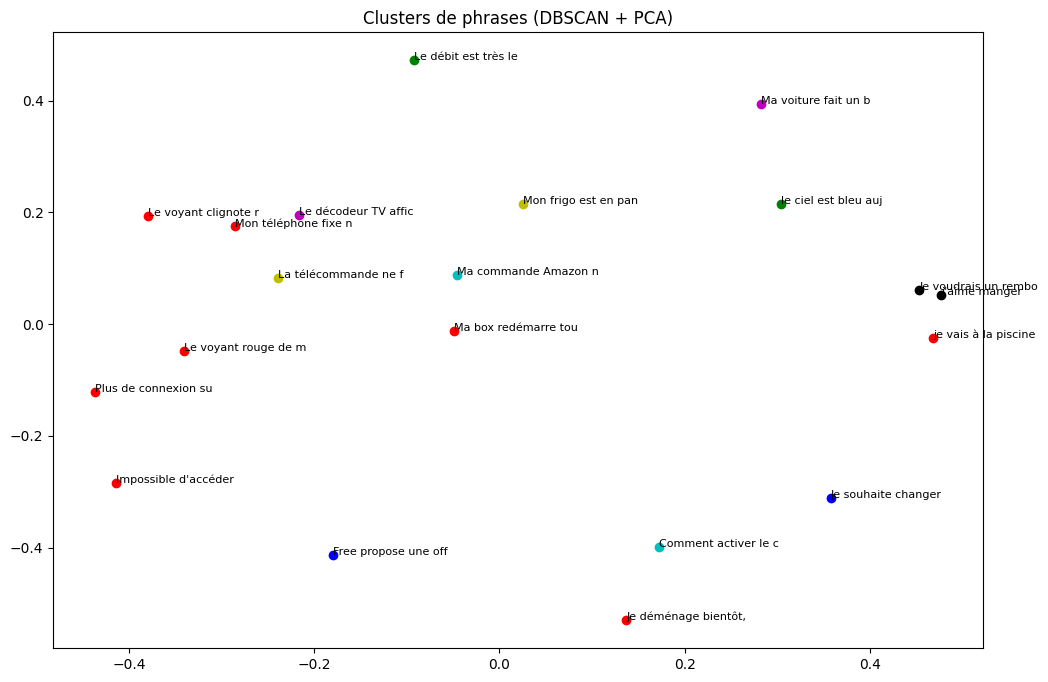

In [23]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Réduire les embeddings à 2D
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Tracer les clusters
plt.figure(figsize=(12, 8))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
for i, label in enumerate(clustering.labels_):
    if label == -1:
        color = 'gray'  # Bruit
    else:
        color = colors[label % len(colors)]
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], c=color)
    plt.annotate(sentences[i][:20], (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8)

plt.title("Clusters de phrases (DBSCAN + PCA)")
plt.show()


In [26]:
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import numpy as np
import torch
from sentence_transformers import SentenceTransformer
from transformers import FlaubertModel, FlaubertTokenizer

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def evaluate_encoder(encoder_name, sentences, eps=0.6, min_samples=1):
    if "sentence-transformers" in encoder_name or "dangvantuan" in encoder_name:
        model = SentenceTransformer(encoder_name)
        embeddings = model.encode(sentences, convert_to_tensor=False)
    elif "flaubert" in encoder_name:
        tokenizer = FlaubertTokenizer.from_pretrained(encoder_name, do_lowercase=False)
        model = FlaubertModel.from_pretrained(encoder_name)
        inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt", max_length=128)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = mean_pooling(outputs, inputs['attention_mask']).numpy()
    else:
        raise ValueError(f"Encodeur non supporté : {encoder_name}")

    # Normaliser les embeddings
    embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

    # Appliquer DBSCAN
    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine').fit(embeddings)

    # Afficher les clusters
    groupes = defaultdict(list)
    for i, label in enumerate(clustering.labels_):
        groupes[label].append(sentences[i])

    print(f"\n🔹 Résultats pour {encoder_name} (eps={eps}, min_samples={min_samples}):")
    for label, phrases in groupes.items():
        if label == -1:
            print("\n🔸 Bruit (phrases non regroupées) :")
        else:
            print(f"\n🔸 Groupe {label + 1} :")
        for phrase in phrases:
            print(f"→ {phrase}")

    # Retourner les labels pour évaluation
    return clustering.labels_

sentences = [
    "Le voyant rouge de ma Freebox clignote",
    "Plus de connexion sur ma Freebox, panne totale",
    "Le voyant clignote rouge et plus d'accès Internet",
    "Ma box redémarre toute seule sans arrêt",
    "Impossible d'accéder à Netflix via la Freebox",
    "Le débit est très lent depuis 3 jours",
    "Je souhaite changer mon mot de passe Wi-Fi",
    "Comment activer le contrôle parental sur la box ?",
    "Mon téléphone fixe ne reçoit plus d'appel",
    "Le décodeur TV affiche erreur E10",
    "La télécommande ne fonctionne plus",
    "j'aime manger",
    "je vais à la piscine tous les samedis",
    "le ciel est bleu aujourd'hui",
    "Free propose une offre à 5 euros par mois",
    "Ma commande Amazon n’a pas été livrée",
    "Ma voiture fait un bruit bizarre",
    "Mon frigo est en panne",
    "Je voudrais un remboursement",
    "Je déménage bientôt, comment transférer mon abonnement Free ?"
]

# Tester les 3 encodeurs
encodeurs = [
    "dangvantuan/sentence-camembert-large",
    "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
    "flaubert/flaubert_base_cased"
]

for encoder in encodeurs:
    try:
        labels = evaluate_encoder(encoder, sentences)
    except Exception as e:
        print(f"Erreur avec {encoder}: {e}")


No sentence-transformers model found with name dangvantuan/sentence-camembert-large. Creating a new one with mean pooling.



🔹 Résultats pour dangvantuan/sentence-camembert-large (eps=0.6, min_samples=1):

🔸 Groupe 1 :
→ Le voyant rouge de ma Freebox clignote
→ Plus de connexion sur ma Freebox, panne totale
→ Le voyant clignote rouge et plus d'accès Internet
→ Ma box redémarre toute seule sans arrêt
→ Impossible d'accéder à Netflix via la Freebox
→ Mon téléphone fixe ne reçoit plus d'appel

🔸 Groupe 2 :
→ Le débit est très lent depuis 3 jours

🔸 Groupe 3 :
→ Je souhaite changer mon mot de passe Wi-Fi

🔸 Groupe 4 :
→ Comment activer le contrôle parental sur la box ?

🔸 Groupe 5 :
→ Le décodeur TV affiche erreur E10

🔸 Groupe 6 :
→ La télécommande ne fonctionne plus

🔸 Groupe 7 :
→ j'aime manger

🔸 Groupe 8 :
→ je vais à la piscine tous les samedis

🔸 Groupe 9 :
→ le ciel est bleu aujourd'hui

🔸 Groupe 10 :
→ Free propose une offre à 5 euros par mois

🔸 Groupe 11 :
→ Ma commande Amazon n’a pas été livrée

🔸 Groupe 12 :
→ Ma voiture fait un bruit bizarre

🔸 Groupe 13 :
→ Mon frigo est en panne

🔸 Groupe 14 :
→

In [ ]:
import torch
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, f1_score
from collections import defaultdict
from sentence_transformers import SentenceTransformer
from transformers import FlaubertModel, FlaubertTokenizer


def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


def labelliser_groupes_semantique(groupes, exemples_techniques, model, seuil_sim=0.55):
    groupes_labellises = {}
    emb_tech = model.encode(exemples_techniques, convert_to_tensor=True)

    for label, phrases in groupes.items():
        emb_phrases = model.encode(phrases, convert_to_tensor=True)
        sims = util.cos_sim(emb_phrases, emb_tech)  # shape = (nb_phrases, nb_tech)
        max_sim = sims.max().item() if sims.numel() > 0 else 0
        type_detecte = "Technique" if max_sim >= seuil_sim else "Générique"
        groupes_labellises[label] = {"type": type_detecte, "phrases": phrases}
    return groupes_labellises
def calculer_scores(groupes_labellises, sentences, labels_manuels):
    labels_predits = [-1] * len(sentences)
    for label, groupe in groupes_labellises.items():
        for phrase in groupe['phrases']:
            index = sentences.index(phrase)
            labels_predits[index] = 1 if groupe['type'] == 'Technique' else 0

    precision = precision_score(labels_manuels, labels_predits, pos_label=1, zero_division=0)
    f1 = f1_score(labels_manuels, labels_predits, pos_label=1, zero_division=0)
    return precision, f1, labels_predits


def sauvegarder_groupes_csv(groupes_labellises, output_path="groupes_clusters.csv"):
    lignes = []
    for label, groupe in groupes_labellises.items():
        for phrase in groupe["phrases"]:
            lignes.append({
                "phrase": phrase,
                "groupe": label,
                "type": groupe["type"]
            })
    df = pd.DataFrame(lignes)
    df.to_csv(output_path, index=False, encoding='utf-8')
    print(f"✅ Résultats sauvegardés dans {output_path}")


def evaluate_encoder(encoder_name, sentences, labels_manuels, mots_cles_techniques, eps=0.6, min_samples=1):
    if "sentence-transformers" in encoder_name or "dangvantuan" in encoder_name:
        model = SentenceTransformer(encoder_name)
        embeddings = model.encode(sentences, convert_to_tensor=False)
    elif "flaubert" in encoder_name:
        tokenizer = FlaubertTokenizer.from_pretrained(encoder_name, do_lowercase=False)
        model = FlaubertModel.from_pretrained(encoder_name)
        inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt", max_length=128)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = mean_pooling(outputs, inputs['attention_mask']).numpy()
    else:
        raise ValueError(f"Encodeur non supporté : {encoder_name}")

    embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine').fit(embeddings)

    groupes = defaultdict(list)
    for i, label in enumerate(clustering.labels_):
        groupes[label].append(sentences[i])

    groupes_labellises = labelliser_groupes_semantique(groupes, exemples_techniques=phrases_techniques, model=model)

    precision, f1, _ = calculer_scores(groupes_labellises, sentences, labels_manuels)

    print(f"\n📊 Résultats pour {encoder_name}")
    print(f"   ↪ Précision : {precision:.2f}")
    print(f"   ↪ F1-score  : {f1:.2f}")

    csv_name = f"groupes_{encoder_name.replace('/', '_')}.csv"
    sauvegarder_groupes_csv(groupes_labellises, output_path=csv_name)

    return groupes_labellises, precision, f1


# ------------------------
# Données à traiter
# ------------------------

sentences = [
    "Le voyant rouge de ma Freebox clignote",
    "Plus de connexion sur ma Freebox, panne totale",
    "Le voyant clignote rouge et plus d'accès Internet",
    "Ma box redémarre toute seule sans arrêt",
    "Impossible d'accéder à Netflix via la Freebox",
    "Le débit est très lent depuis 3 jours",
    "Je souhaite changer mon mot de passe Wi-Fi",
    "Comment activer le contrôle parental sur la box ?",
    "Mon téléphone fixe ne reçoit plus d'appel",
    "Le décodeur TV affiche erreur E10",
    "La télécommande ne fonctionne plus",
    "j'aime manger",
    "je vais à la piscine tous les samedis",
    "le ciel est bleu aujourd'hui",
    "Free propose une offre à 5 euros par mois",
    "Ma commande Amazon n’a pas été livrée",
    "Ma voiture fait un bruit bizarre",
    "Mon frigo est en panne",
    "Je voudrais un remboursement",
    "Je déménage bientôt, comment transférer mon abonnement Free ?"
]

mots_cles_techniques = [
    "freebox", "box", "voyant", "connexion", "internet", "débit", "redémarre",
    "netflix", "wifi", "téléphone fixe", "décodeur", "télécommande", "erreur",
    "panne", "accès", "clignote", "mot de passe", "contrôle parental"
]

labels_manuels = [
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1
]

# ------------------------
# Tests d'encoders
# ------------------------

encodeurs = [
    "dangvantuan/sentence-camembert-large",
    "intfloat/multilingual-e5-base",
    "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
    "jinaai/jina-embeddings-v2-base-en"
    # "flaubert/flaubert_base_uncased"  # facultatif
]

for encoder in encodeurs:
    try:
        evaluate_encoder(encoder, sentences, labels_manuels, mots_cles_techniques, eps=0.55)
    except Exception as e:
        print(f"❌ Erreur avec {encoder}: {e}")


No sentence-transformers model found with name dangvantuan/sentence-camembert-large. Creating a new one with mean pooling.



📊 Résultats pour dangvantuan/sentence-camembert-large
   ↪ Précision : 0.92
   ↪ F1-score  : 0.92
✅ Résultats sauvegardés dans groupes_dangvantuan_sentence-camembert-large.csv
❌ Erreur avec intfloat/multilingual-e5-base: Encodeur non supporté : intfloat/multilingual-e5-base

📊 Résultats pour sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
   ↪ Précision : 0.75
   ↪ F1-score  : 0.86
✅ Résultats sauvegardés dans groupes_sentence-transformers_paraphrase-multilingual-MiniLM-L12-v2.csv
❌ Erreur avec jinaai/jina-embeddings-v2-base-en: Encodeur non supporté : jinaai/jina-embeddings-v2-base-en


No sentence-transformers model found with name dangvantuan/sentence-camembert-large. Creating a new one with mean pooling.



📊 Résultats pour dangvantuan/sentence-camembert-large
   ↪ Précision : 0.92
   ↪ F1-score  : 0.92
✅ Résultats sauvegardés dans groupes_dangvantuan_sentence-camembert-large.csv


Some weights of BertModel were not initialized from the model checkpoint at jinaai/jina-embeddings-v2-base-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encoder.layer.10.intermediate.dense.bias', 'encoder.layer.10.intermediate.dense.weight', 'encoder.layer.10.output.LayerNorm.bias', 'encoder.layer.10.output.LayerNorm.weight', 'encoder.layer.10.output.dense.bias', 'encoder.layer.10.output.dense.weight', 'encoder.layer.11.intermediate.dense.bias', 'encoder.layer.11.intermedi

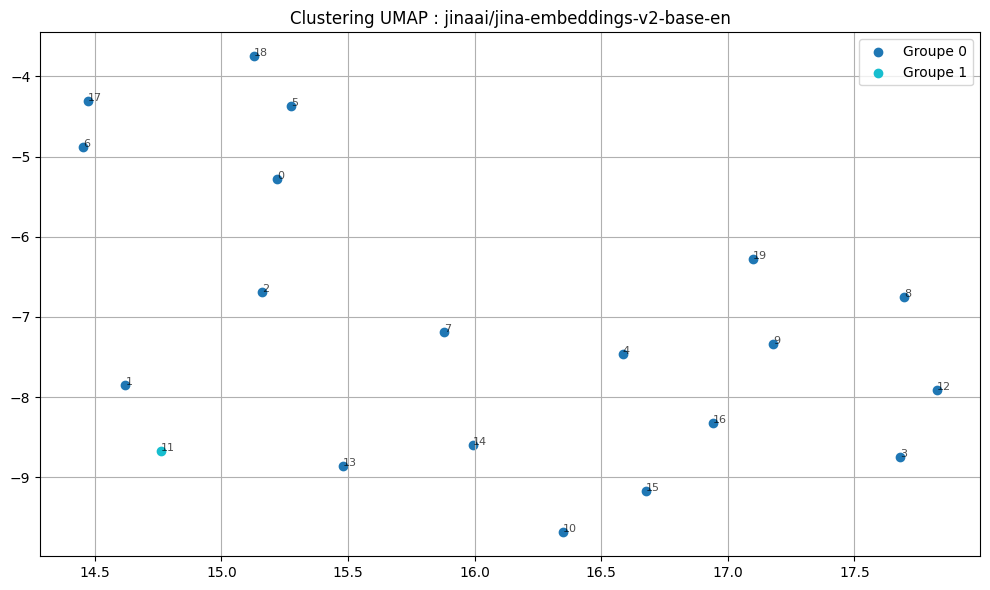

In [44]:
# Appel de evaluate_encoder
groupes_labellises, precision, f1 =evaluate_encoder("dangvantuan/sentence-camembert-large", sentences, labels_manuels, mots_cles_techniques)

# Extraire les embeddings
if "flaubert" in encoder:
    # déjà défini dans evaluate_encoder
    pass
else:
    model = SentenceTransformer(encoder)
    embeddings = model.encode(sentences, convert_to_tensor=False)

# Extraire les labels de clustering
clustering = DBSCAN(eps=0.6, min_samples=1, metric='cosine').fit(embeddings)
clustering_labels = clustering.labels_

# Visualisation
visualiser_clusters(embeddings, clustering_labels, sentences, title=f"Clustering UMAP : {encoder}")


In [6]:
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity

mots_cles_techniques = [
    "freebox", "box", "voyant", "connexion", "internet", "débit", "redémarre",
    "netflix", "wifi", "téléphone fixe", "décodeur", "télécommande", "erreur",
    "panne", "accès", "clignote", "mot de passe", "contrôle parental"
    ]
azz = "manger ne sert à rien"

model_name = "dangvantuan/sentence-camembert-large"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
model = SentenceTransformer(model_name)
model.tokenizer = tokenizer

embeddings = model.encode(mots_cles_techniques, convert_to_tensor=True, normalize_embeddings=True)
emb_tech = model.encode(azz, convert_to_tensor=True)


sim_scores = cosine_similarity(embeddings.cpu(), emb_tech.cpu().unsqueeze(0))
for mot, score in sorted(zip(mots_cles_techniques, sim_scores.flatten()), key=lambda x: x[1], reverse=True):
    print(f"{mot:20s} → Similarité : {score:.4f}")

No sentence-transformers model found with name dangvantuan/sentence-camembert-large. Creating a new one with mean pooling.


clignote             → Similarité : 0.1167
panne                → Similarité : 0.1103
mot de passe         → Similarité : 0.1060
redémarre            → Similarité : 0.0744
contrôle parental    → Similarité : 0.0546
accès                → Similarité : 0.0523
connexion            → Similarité : 0.0481
voyant               → Similarité : 0.0458
débit                → Similarité : 0.0429
internet             → Similarité : 0.0313
netflix              → Similarité : 0.0246
décodeur             → Similarité : 0.0170
téléphone fixe       → Similarité : 0.0058
wifi                 → Similarité : 0.0020
télécommande         → Similarité : -0.0000
erreur               → Similarité : -0.0147
box                  → Similarité : -0.0811
freebox              → Similarité : -0.0922


In [7]:
import torch
from sentence_transformers import SentenceTransformer

mots_cles_techniques = [
    "freebox", "box", "voyant", "connexion", "internet", "débit", "redémarre",
    "netflix", "wifi", "téléphone fixe", "décodeur", "télécommande", "erreur",
    "panne", "accès", "clignote", "mot de passe", "contrôle parental"
]

model = SentenceTransformer("dangvantuan/sentence-camembert-large")
embeddings = model.encode(mots_cles_techniques, convert_to_tensor=True, normalize_embeddings=True)

# Chemin de sauvegarde
save_path = r"C:\Users\Eliot\Desktop\projet_rncp\SAVIA-API-LLM\knowledge\gold\tech_keywords.pt"

# Sauvegarde
torch.save({
    "keywords": mots_cles_techniques,
    "embeddings": embeddings
}, save_path)

print("✅ Embeddings sauvegardés.")


No sentence-transformers model found with name dangvantuan/sentence-camembert-large. Creating a new one with mean pooling.


✅ Embeddings sauvegardés.


In [12]:
import torch

load_path = r"C:\Users\Eliot\Desktop\projet_rncp\SAVIA-API-LLM\knowledge\gold\tech_keywords.pt"

# Chargement
data = torch.load(load_path)
keywords = data["keywords"]
embeddings = data["embeddings"]

print(f"✅ {len(keywords)} mots-clés techniques chargés.")


✅ 18 mots-clés techniques chargés.


In [13]:
print(embeddings)

tensor([[ 0.0283,  0.0203,  0.0354,  ..., -0.0233,  0.0170, -0.0184],
        [ 0.0169,  0.0226, -0.0041,  ..., -0.0005,  0.0248,  0.0111],
        [-0.0145,  0.0079,  0.0115,  ..., -0.0044,  0.0090, -0.0252],
        ...,
        [-0.0247,  0.0234, -0.0360,  ...,  0.0299, -0.0309,  0.0297],
        [-0.0706,  0.0575, -0.0090,  ...,  0.0222,  0.1150,  0.0148],
        [ 0.0366,  0.0366, -0.0313,  ...,  0.0605,  0.0709, -0.0018]])


In [15]:
import os
import torch
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity

# Chargement du modèle
def load_model_embedder():
    model_name = "dangvantuan/sentence-camembert-large"
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
    model = SentenceTransformer(model_name)
    model.tokenizer = tokenizer
    return model

# Détection du chemin dynamique
def load_technical_embeddings():
    base_dir = os.path.dirname(os.path.abspath(__file__))
    emb_path = os.path.join(base_dir, "knowledge", "gold", "tech_keywords.pt")
    data = torch.load(emb_path)
    return data["keywords"], data["embeddings"]

# Fonction de comparaison
def word_domain(technical_embedded, sentence, model, keywords, threshold=0.45):
    sent_emb = model.encode(sentence, convert_to_tensor=True, normalize_embeddings=True)
    sim_scores = cosine_similarity(technical_embedded.cpu(), sent_emb.cpu().unsqueeze(0))

    # Affichage filtré
    for mot, score in sorted(zip(keywords, sim_scores.flatten()), key=lambda x: x[1], reverse=True):
        tag = "✅" if score > threshold else "❌"
        print(f"{tag} {mot:20s} → Similarité : {score:.4f}")
    
    if sim_scores.max() > threshold:
        print("\n✅ Phrase considérée comme TECHNIQUE.")
    else:
        print("\n❌ Phrase considérée comme NON TECHNIQUE.")

# Exécution
if __name__ == "__main__":
    model = load_model_embedder()
    keywords, embeddings = load_technical_embeddings()

    test_phrase = "je n'aime pas manger"
    word_domain(embeddings, test_phrase, model, keywords)


No sentence-transformers model found with name dangvantuan/sentence-camembert-large. Creating a new one with mean pooling.


NameError: name '__file__' is not defined